In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax_cltv.datasets.dummy import DummySubscriptions
from jax_cltv.models.mle import MLE
from jax_cltv.dists.normal import rv_samples as normal_rv_samples
from jax_cltv.dists.geom import Geometric, neg_loglikelihood, survival_functions
from jax_cltv.plots.plot_data import plot_churns, plot_survives
from sklearn.model_selection import train_test_split
from jax_cltv.utils.ltv import calc_ltv, get_survives_from_churns

plt.style.use('ggplot')

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def init_variables(to_delete: list) -> None:
    for v in to_delete:
        try: 
            del v
        except:
            pass

In [3]:
theta_true_1 = 0.7
theta_true_2 = 0.1

# ds1, data1 = DummySubscriptions(p=theta_true_1, size=800)()
# ds2, data2 = DummySubscriptions(p=theta_true_2, size=200)()
df1 = DummySubscriptions(p=theta_true_1, size=800).to_pandas()
df2 = DummySubscriptions(p=theta_true_2, size=200).to_pandas()

In [4]:
df1['segment'] = 'A'
df2['segment'] = 'B'

df = pd.concat([df2, df1], ignore_index=True)
df = df.fillna(0)

In [127]:
df

,churn_dates,segment
0,2,B
1,15,B
2,1,B
3,6,B
4,8,B
...,...,...
995,1,A
996,1,A
997,2,A
998,1,A


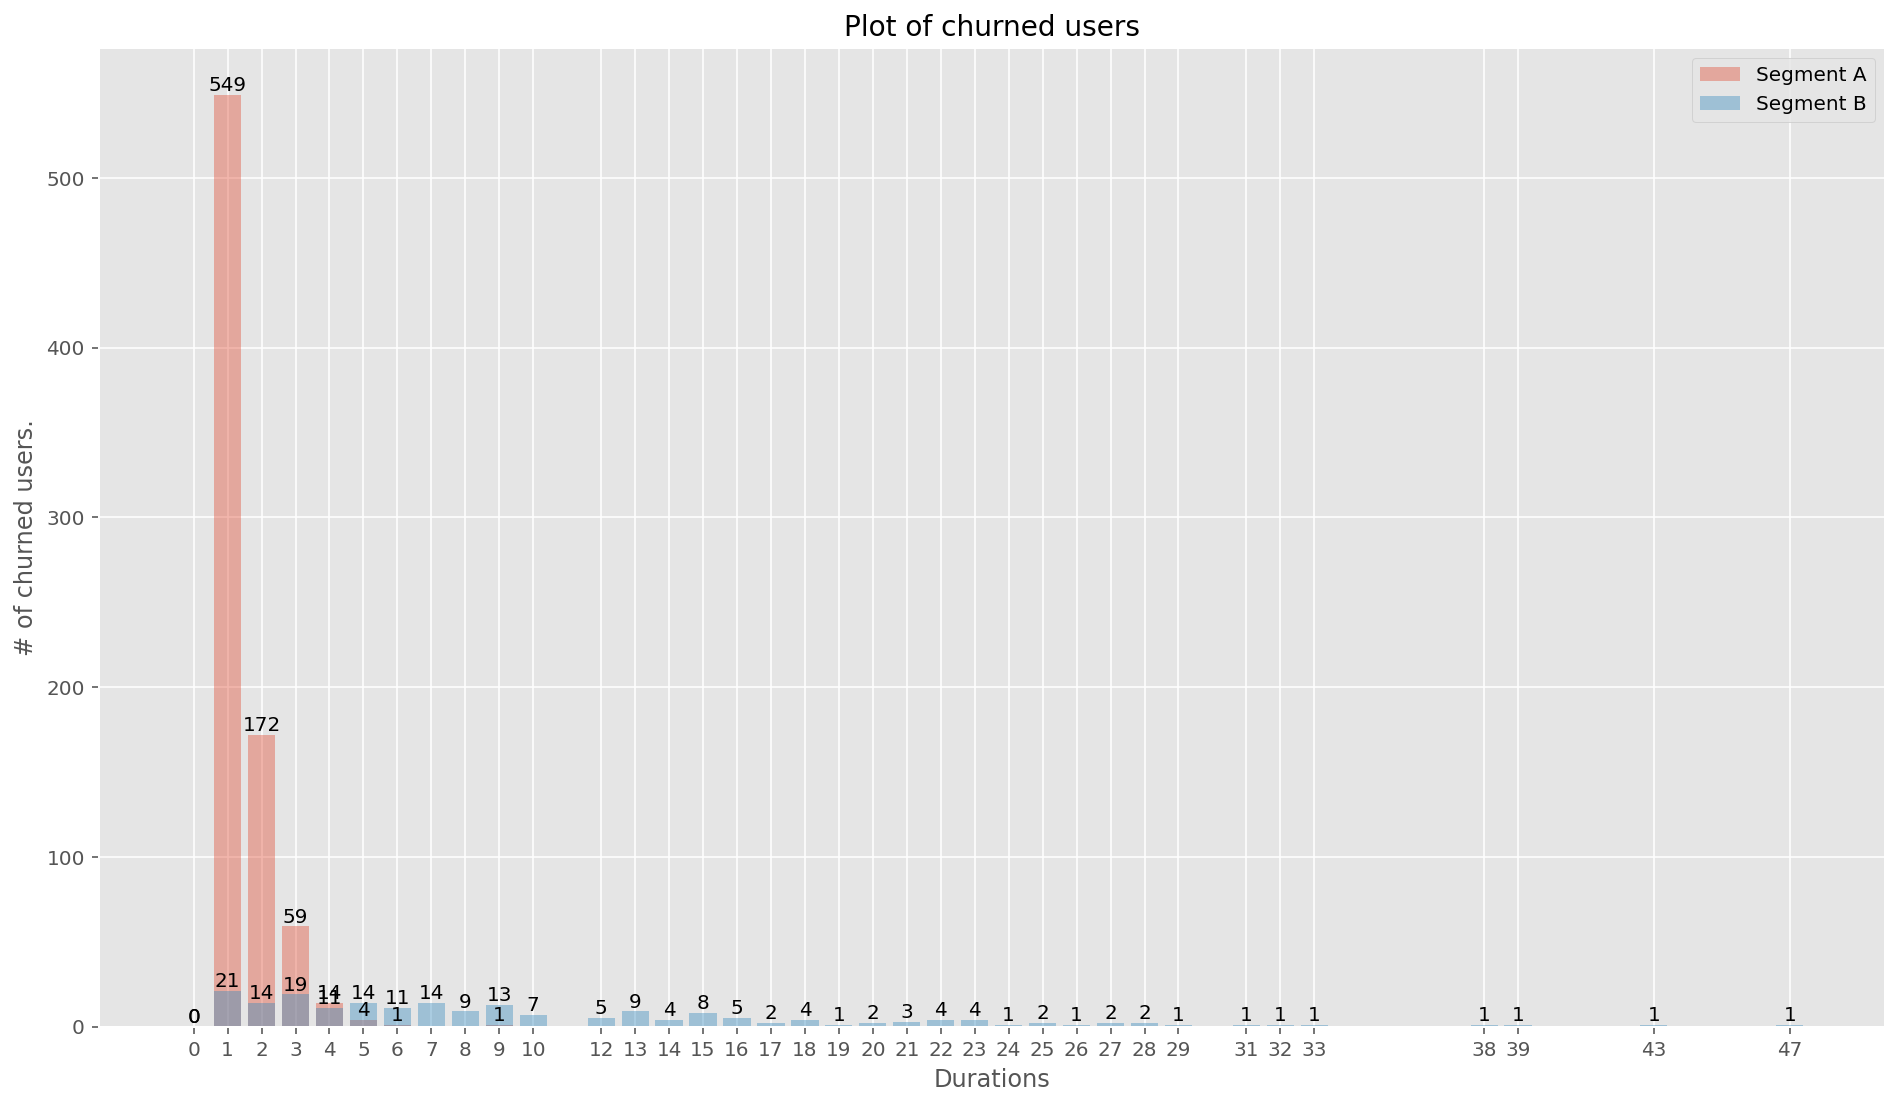

In [5]:
ax = plot_churns(df[df['segment']=='A'], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
ax = plot_churns(df[df['segment']=='B'], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)
plt.show()

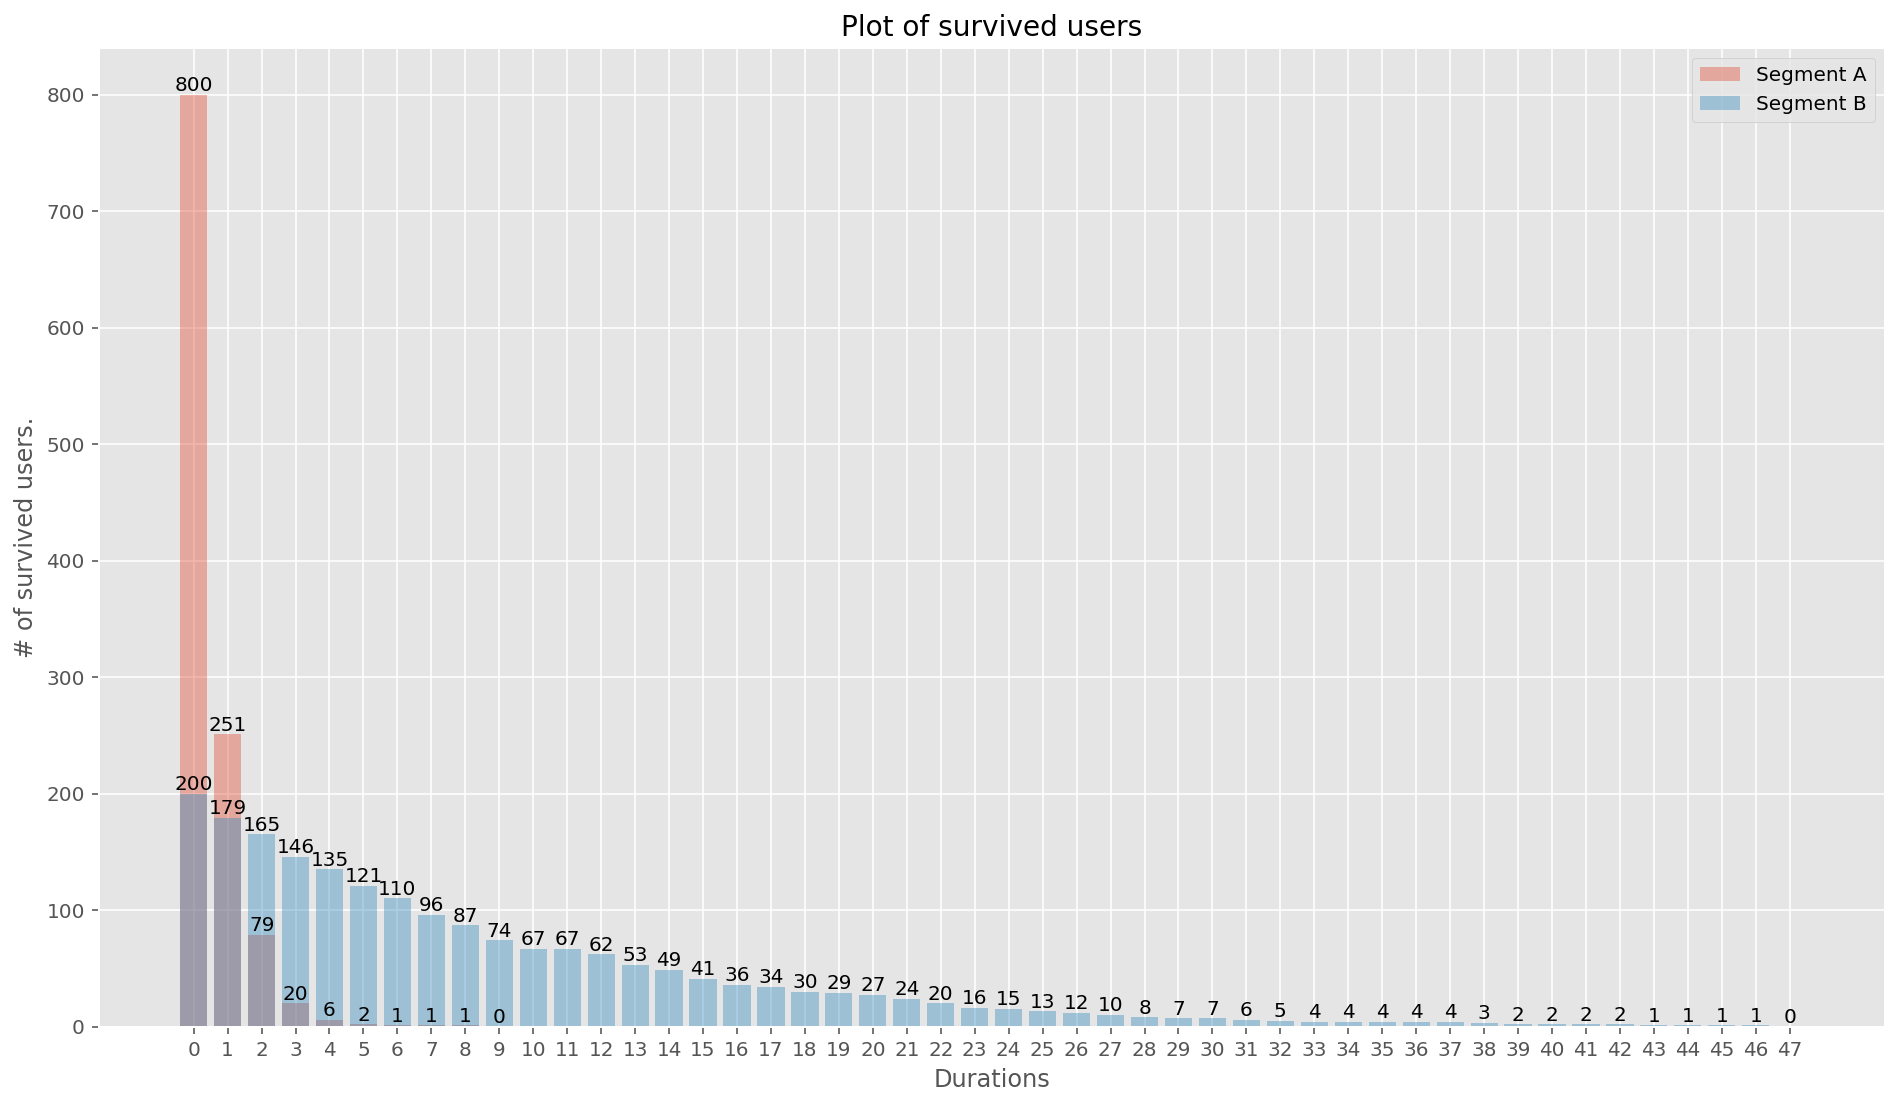

In [6]:

ax = plot_survives(df[df['segment']=='A'], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
ax = plot_survives(df[df['segment']=='B'], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)
plt.show()

## Bayesian inference with PyMC4

In [8]:
import arviz as az
import pymc as pm

az.style.use("arviz-darkgrid")

In [9]:
print(f'Running on pymc version: {pm.__version__}')

Running on pymc version: 4.1.5


### 2nd sample: Geometric distribution

In [10]:
df['segment_id'] = pd.Categorical(df['segment']).codes

In [11]:
df_train, df_test = train_test_split(df.loc[:, df.columns != 'segment'], test_size=0.3, random_state=1)

In [134]:
df_train

,churn_dates,segment_id
731,1,0
716,1,0
640,1,0
804,2,0
737,1,0
...,...,...
767,1,0
72,5,1
908,1,0
235,2,0


In [12]:
X_train, X_test = df_train['segment_id'], df_test['segment_id']
y_train, y_test = df_train['churn_dates'], df_test['churn_dates']
# y_train, y_test = df_train.sum(axis=1).astype('int'), df_test.sum(axis=1).astype('int')
# X_train = X_train.apply(lambda r: 1 if r=='B' else 0)
# X_test = X_test.apply(lambda r: 1 if r=='B' else 0)

In [13]:
init_variables(['idata', 'model'])

model = pm.Model()

with model:
    # alpha = pm.HalfNormal('alpha', sigma=100)
    # beta = pm.HalfNormal('beta', sigma=100)
    # theta_core = pm.Beta('theta_core', 1., 1.)
    # mu = pm.Normal('mu', 0., 0.1, shape=[X_train.max()+1])
    # sigma = pm.HalfNormal('sigma', sigma=0.1)
    x_ = pm.Data('features', X_train.values, mutable=True)
    theta = pm.Beta('theta', 1., 1., shape=[X_train.max()+1])

    # theta = pm.Beta('theta', alpha[X_train.values], beta[X_train.values])  # + tscale
    # theta = pm.Deterministic('theta', theta_core + mu[X_train.values])
    # obs = pm.Geometric('obs', theta_core + mu[X_train.values], observed=y_train.values)
    # obs = pm.Geometric('obs', theta_core + mu[x_], observed=y_train.values)
    obs = pm.Geometric('obs', theta[x_], observed=y_train.values)
    # obs = pm.Geometric('obs', theta, observed=y_train.values)


In [14]:
with model:
    idata = pm.sample(draws=2000, target_accept=0.9)

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma 

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.704,0.016,0.673,0.733,0.0,0.0,7597.0,5214.0,1.0
theta[1],0.103,0.008,0.088,0.118,0.0,0.0,7189.0,5205.0,1.0


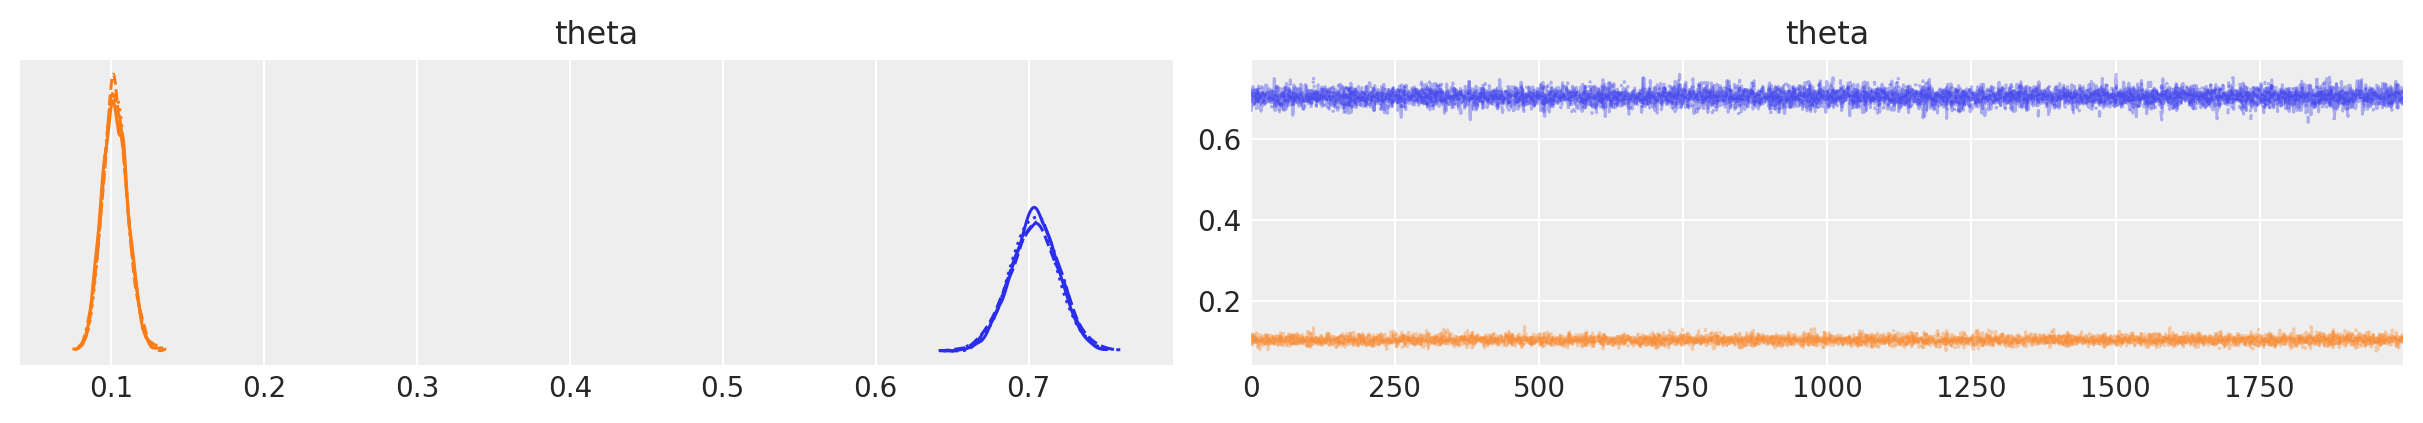

In [16]:
az.plot_trace(idata, ['theta']);

In [17]:
az.waic(idata)

Computed from 8000 posterior samples and 700 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -931.79    35.80
p_waic        1.87        -

In [18]:
with model:
    pm.set_data({'features': X_test.values})
    posterior = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [19]:
ci95 = az.hdi(posterior.posterior, hdi_prob=0.95)

theta_a = posterior.posterior.theta.mean(['chain', 'draw'])[0]
theta_b = posterior.posterior.theta.mean(['chain', 'draw'])[1]
theta_a_ci95 = ci95['theta'][0]
theta_b_ci95 = ci95['theta'][1]
# theta_a = posterior.posterior.theta_core.mean(['chain', 'draw']) + posterior.posterior.mu.mean(['chain', 'draw'])[0]
# theta_b = posterior.posterior.theta_core.mean(['chain', 'draw']) + posterior.posterior.mu.mean(['chain', 'draw'])[1]
# theta_a_ci95 = ci95['theta_core'] + ci95['mu'][0]
# theta_b_ci95 = ci95['theta_core'] + ci95['mu'][1]


In [21]:
# index_a = df_result[df_result['segment_id']==0].index
# index_b = df_result[df_result['segment_id']==1].index
index_a = df_test[df_test['segment_id']==0].index
index_b = df_test[df_test['segment_id']==1].index

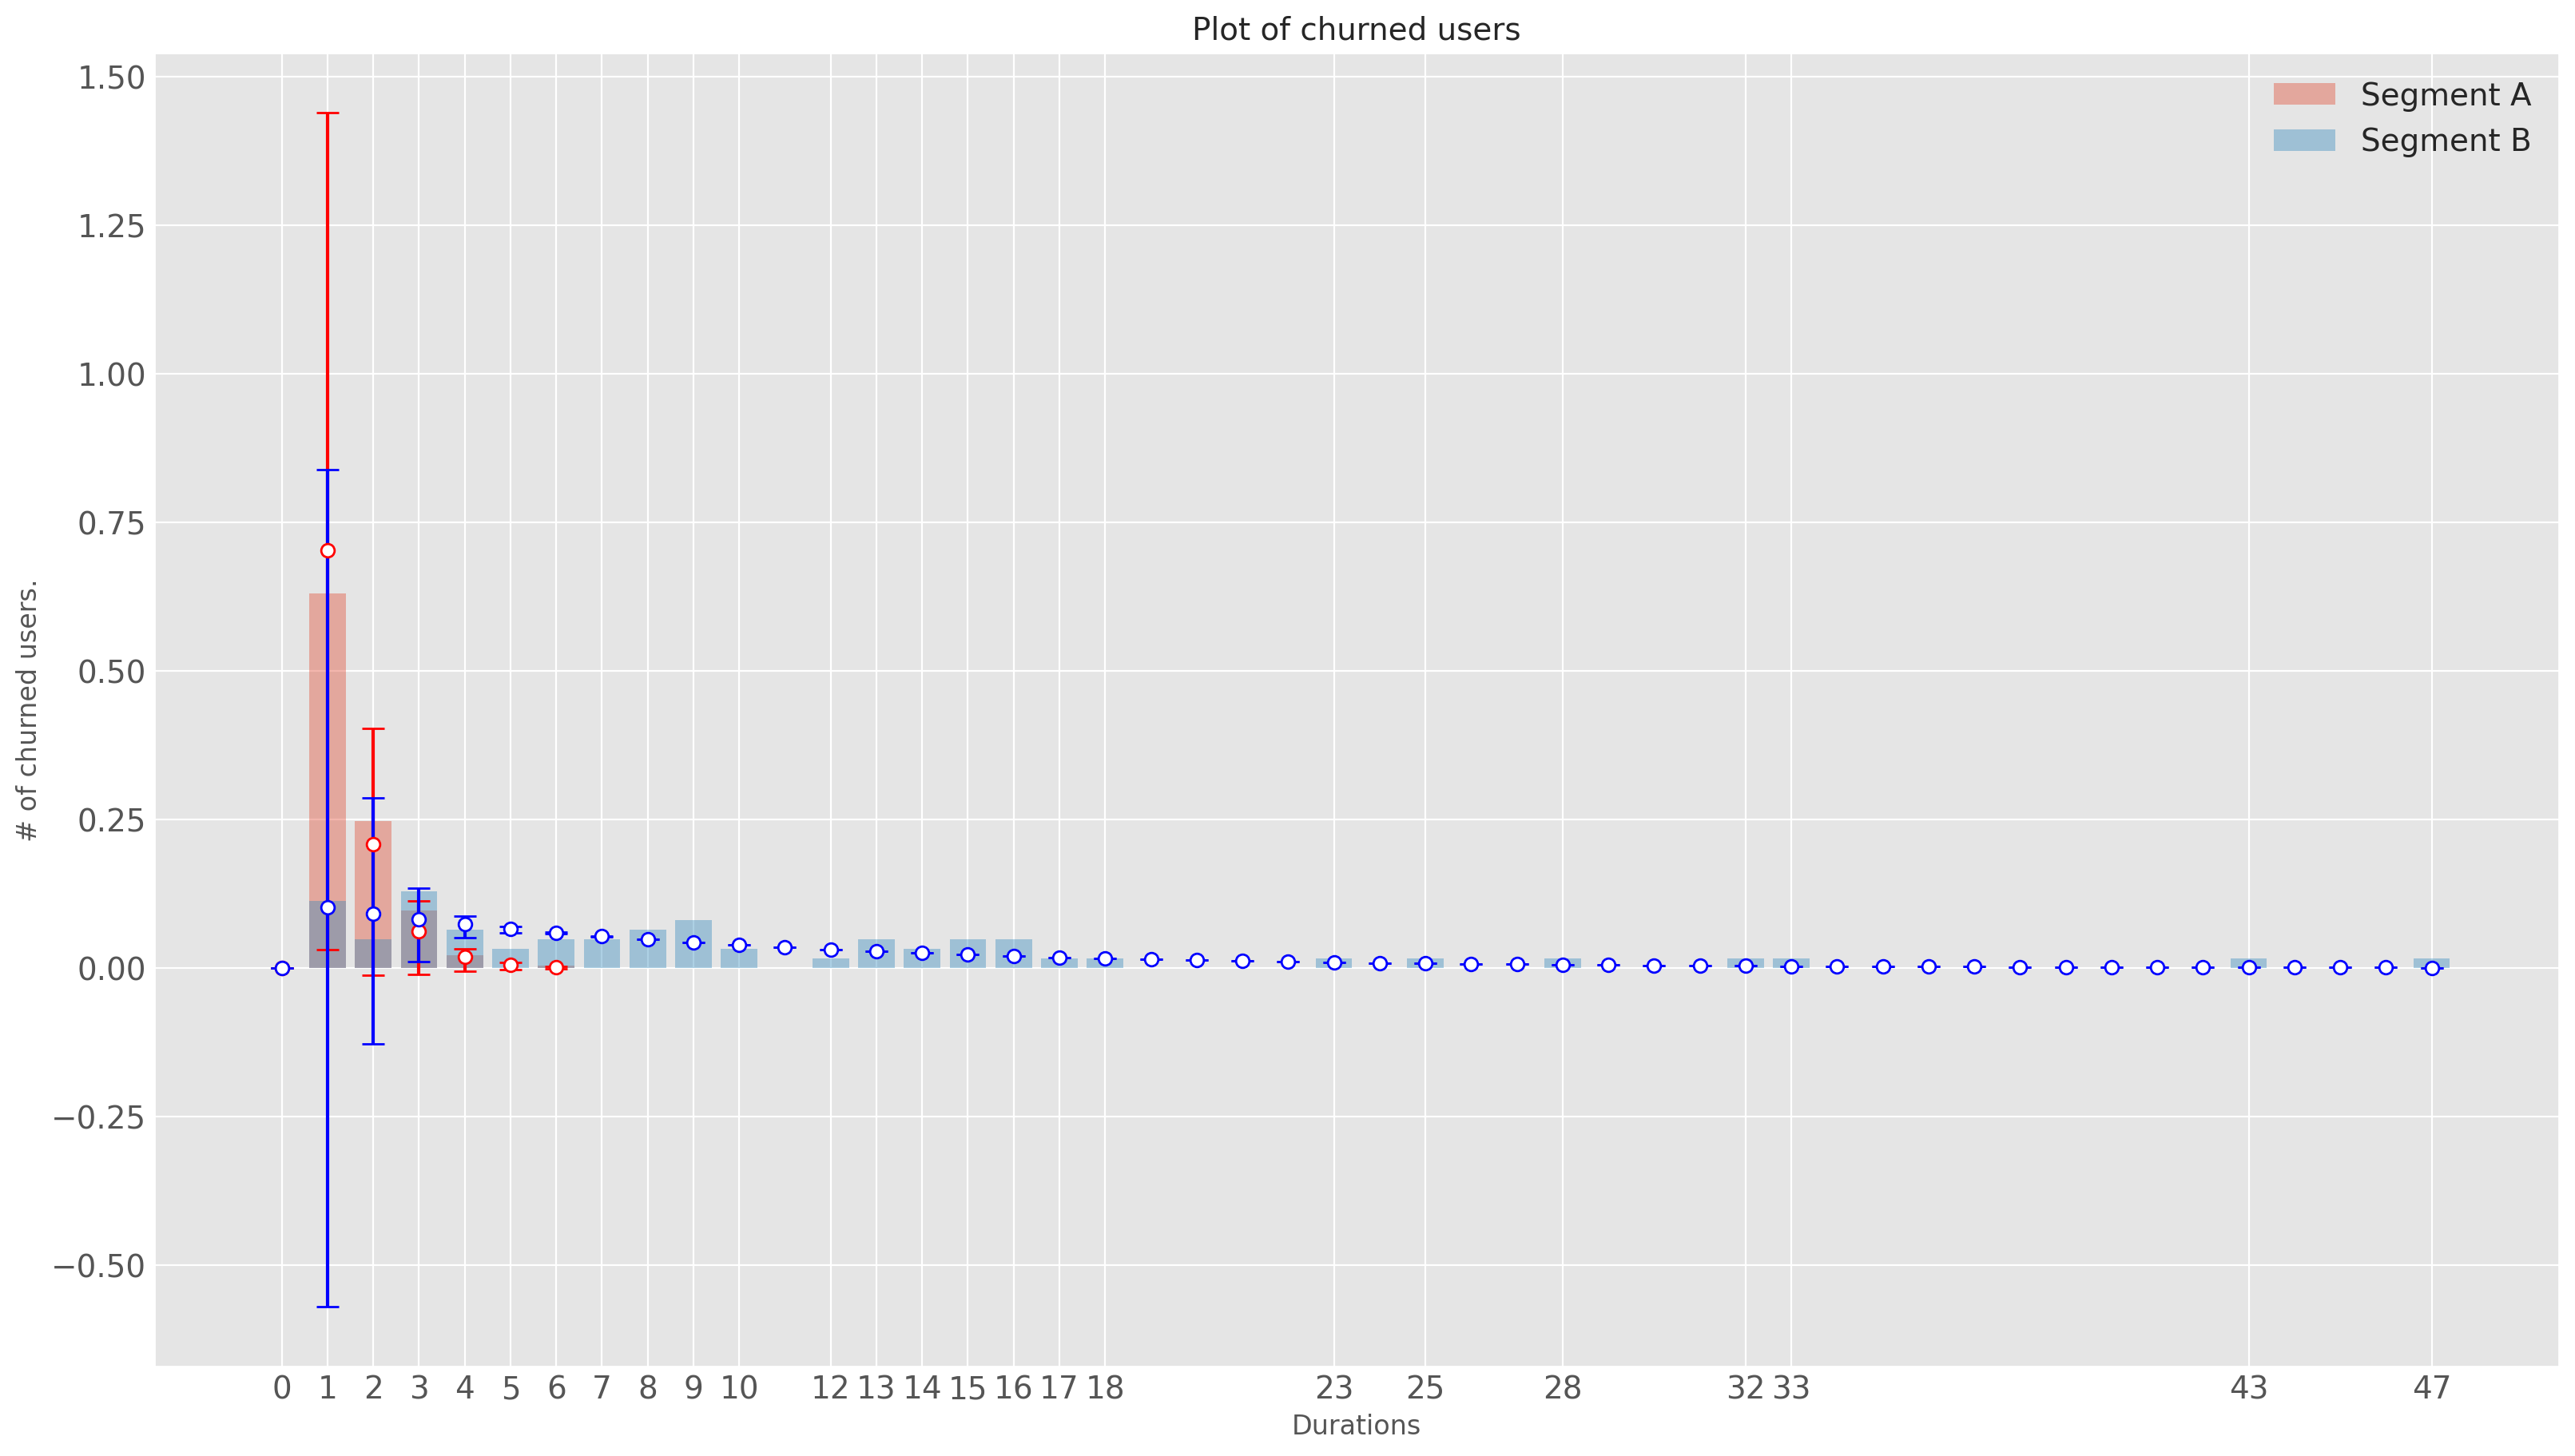

In [24]:
# N_a = df_result.loc[index_a, :].shape[0]
# N_b = df_result.loc[index_b, :].shape[0]

# x_a = np.array(range(df_result.loc[index_a, 'churn_dates'].max()+1))
# x_b = np.array(range(df_result.loc[index_b, 'churn_dates'].max()+1))
# ax = plot_churns(df_result.loc[index_a, :], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
# ax = plot_churns(df_result.loc[index_b, :], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)

N_a = df_test.loc[index_a, :].shape[0]
N_b = df_test.loc[index_b, :].shape[0]

x_a = np.array(range(df_test.loc[index_a, 'churn_dates'].max()+1))
x_b = np.array(range(df_test.loc[index_b, 'churn_dates'].max()+1))
ax = plot_churns(df_test.loc[index_a, :], label='Segment A', yscale='linear', density=True, bar_label=False)  #, bar_label=None, theta=0.7)
ax = plot_churns(df_test.loc[index_b, :], label='Segment B', yscale='linear', density=True, ax=ax, bar_label=False)  #, bar_label=None, theta=0.1)

gd_a = Geometric(theta_a.values)
gd_ci95_a = Geometric(theta_a_ci95.values)
gd_b = Geometric(theta_b.values)
gd_ci95_b = Geometric(theta_b_ci95.values)

yerr_a = gd_ci95_a.pmf(jnp.stack([x_a, x_a]).T).T # * N_a
yerr_b = gd_ci95_a.pmf(jnp.stack([x_b, x_b]).T).T # * N_b
ax.errorbar(x_a, gd_a.pmf(x_a), color='white', ecolor='red', markeredgecolor='red', yerr=yerr_a, fmt='o', capsize=5)
ax.errorbar(x_b, gd_b.pmf(x_b), color='white', ecolor='blue', markeredgecolor='blue', yerr=yerr_b, fmt='o', capsize=5);

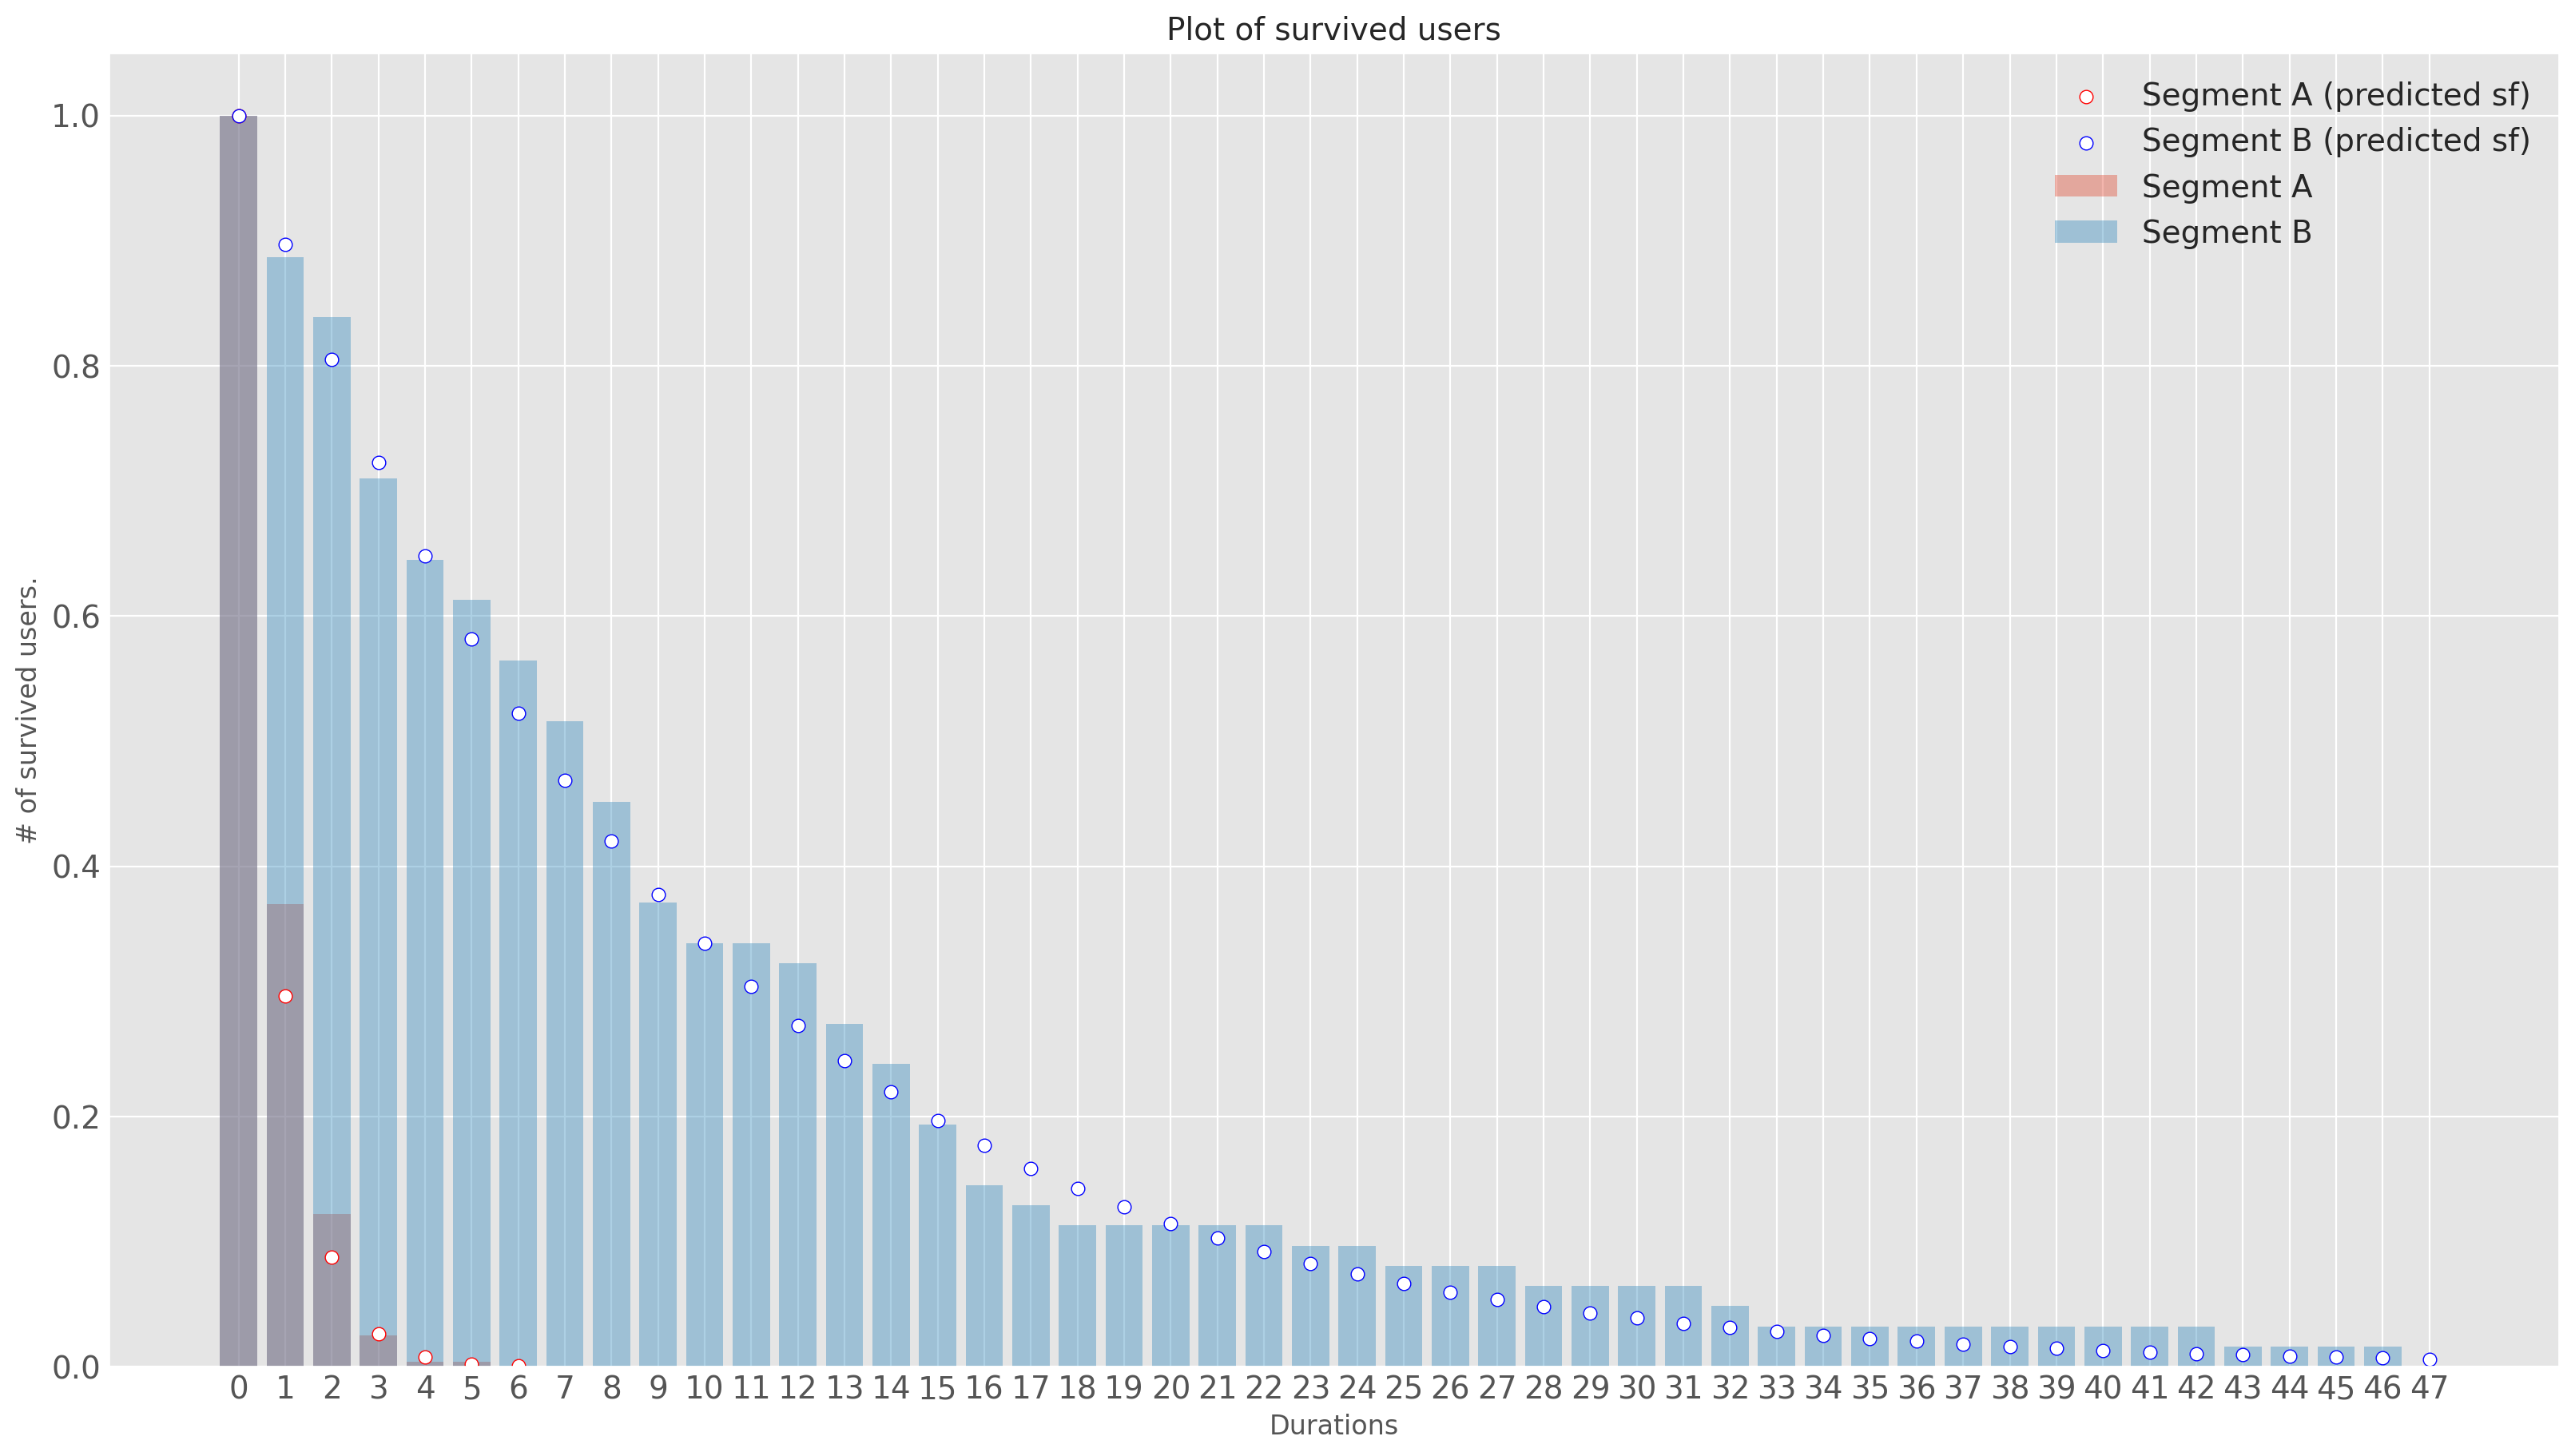

In [88]:
# N_a = df_result.loc[index_a, :].shape[0]
# N_b = df_result.loc[index_b, :].shape[0]

# x_a = np.array(range(df_result.loc[index_a, 'churn_dates'].max()+1))
# x_b = np.array(range(df_result.loc[index_b, 'churn_dates'].max()+1))
# ax = plot_churns(df_result.loc[index_a, :], label='Segment A', yscale='linear', density=False)  #, bar_label=None, theta=0.7)
# ax = plot_churns(df_result.loc[index_b, :], label='Segment B', yscale='linear', density=False, ax=ax)  #, bar_label=None, theta=0.1)

N_a = df_test.loc[index_a, :].shape[0]
N_b = df_test.loc[index_b, :].shape[0]

x_a = np.array(range(df_test.loc[index_a, 'churn_dates'].max()+1))
x_b = np.array(range(df_test.loc[index_b, 'churn_dates'].max()+1))
ax = plot_survives(df_test.loc[index_a, :], label='Segment A', yscale='linear', density=True, bar_label=None)  #, bar_label=None, theta=0.7)
ax = plot_survives(df_test.loc[index_b, :], label='Segment B', yscale='linear', density=True, ax=ax, bar_label=None)  #, bar_label=None, theta=0.1)

gd_a = Geometric(theta_a.values)
gd_ci95_a = Geometric(theta_a_ci95.values)
gd_b = Geometric(theta_b.values)
gd_ci95_b = Geometric(theta_b_ci95.values)

yerr_a = gd_ci95_a.sf(jnp.stack([x_a, x_a]).T).T # * N_a
yerr_b = gd_ci95_b.sf(jnp.stack([x_b, x_b]).T).T # * N_b
ax.scatter(x_a, gd_a.sf(x_a), facecolors='w', edgecolors='r', label='Segment A (predicted sf)')
ax.scatter(x_b, gd_b.sf(x_b), facecolors='w', edgecolors='b', label='Segment B (predicted sf)')
# ax.errorbar(x_a, gd_a.sf(x_a), color='white', ecolor='red', markeredgecolor='red', yerr=yerr_a, fmt='o', capsize=5, label='Segment A (predicted sf)')
# ax.errorbar(x_b, gd_b.sf(x_b), color='white', ecolor='blue', markeredgecolor='blue', yerr=yerr_b, fmt='o', capsize=5, label='Segment B (predicted sf)')
plt.legend();

In [80]:
M = 100
d = 0.15
D = max(x_a.shape[0], x_b.shape[0])

x_a = x_b = jnp.union1d(x_a, x_b)

s_a = get_survives_from_churns(df_test.loc[index_a, :]['churn_dates'], size=D) / N_a
s_b = get_survives_from_churns(df_test.loc[index_b, :]['churn_dates'], size=D) / N_b

ob_cltv_a = calc_ltv(x_a, M, s_a, d)
ob_cltv_b = calc_ltv(x_b, M, s_b, d)
sf_mean_a = gd_a.sf(x_a)
sf_mean_b = gd_b.sf(x_a)
sf_ci95_a = gd_ci95_a.sf(jnp.stack([x_a, x_a]).T).T # * N_a
sf_ci95_b = gd_ci95_b.sf(jnp.stack([x_b, x_b]).T).T # * N_b

pr_cltv_a = calc_ltv(x_a, M, sf_mean_a, d)
pr_cltv_b = calc_ltv(x_b, M, sf_mean_b, d)
err_cltv_a = jnp.stack([calc_ltv(x_a, M, sf_ci95_a[0], d), calc_ltv(x_a, M, sf_ci95_a[1], d)])
err_cltv_b = jnp.stack([calc_ltv(x_b, M, sf_ci95_b[0], d), calc_ltv(x_b, M, sf_ci95_b[1], d)])
# # err_cltv_a = (calc_ltv(x_a, )
# # pred_cltv_a = calc_ltv(x_a, M, d, s=lambda t: s(t, theta_a))
# pred_cltv_b = calc_ltv(x_b, M, d, s=lambda t: s(t, theta_b))

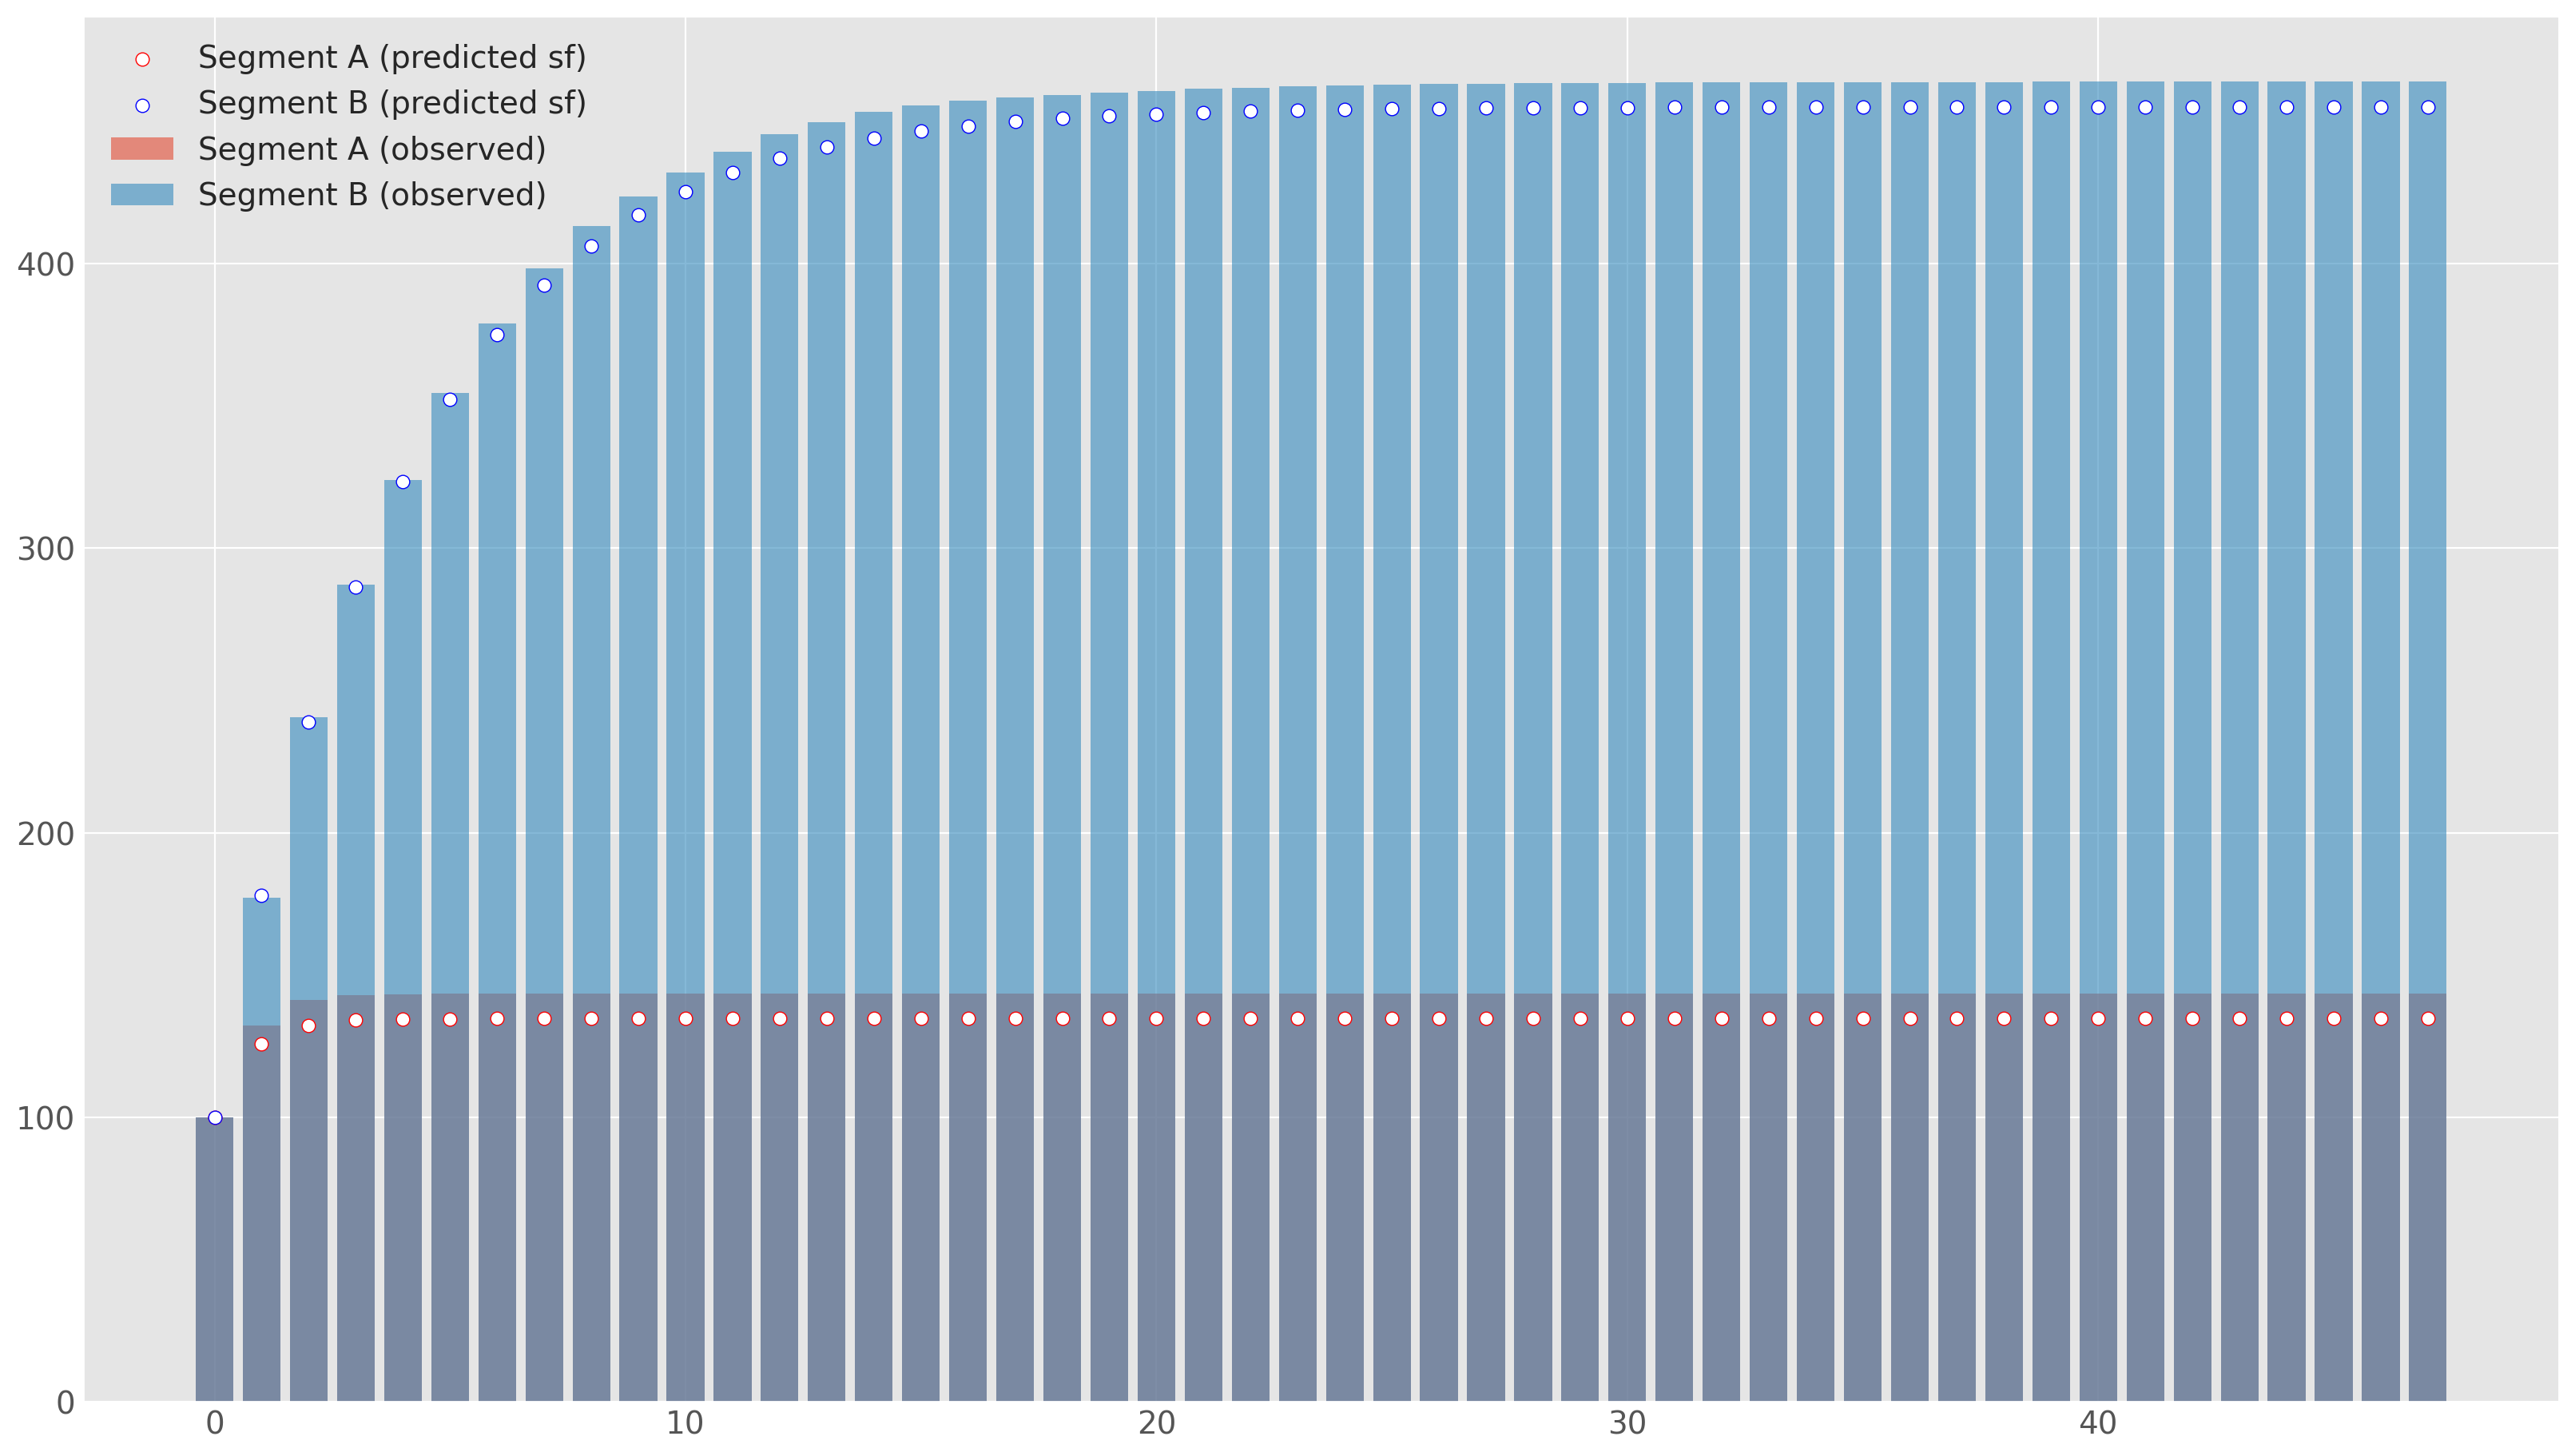

In [87]:
fig = plt.figure(figsize=(16, 9))
plt.bar(x_a, ob_cltv_a, label='Segment A (observed)', alpha=.6)
plt.bar(x_b, ob_cltv_b, label='Segment B (observed)', alpha=.6)
ax = plt.gca()
ax.scatter(x_a, pr_cltv_a, facecolors='w', edgecolors='r', label='Segment A (predicted sf)')
ax.scatter(x_b, pr_cltv_b, facecolors='w', edgecolors='b', label='Segment B (predicted sf)')
# ax.errorbar(x_a, pr_cltv_a, color='white', ecolor='red', markeredgecolor='red', yerr=err_cltv_a, fmt='o', capsize=5, label='Segment A (predicted sf)')
# ax.errorbar(x_b, pr_cltv_b, color='white', ecolor='blue', markeredgecolor='blue', yerr=err_cltv_b, fmt='o', capsize=5, label='Segment B (predicted sf)')
plt.legend(fontsize=14);